In [268]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import sys
sys.path.append('..')
import clusterizer

import random

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Totale ordening in Clusters

Als location_range and time_range beide None zijn, dan is het Cluster het kleinst mogelijke cluster. Anders wordt het gesorteerd volgens het volgende principe:

1) Als iets None is, dan wordt het niet meegenomen in de vergelijking.

2) In een location/time scatter is linksonder het kleinst en rechtsboven het grootst

3) Tijd is belangrijker dan locatie

In [269]:
circuitnr = random.choice(clusterizer.globals.available_circuits)
#circuitnr = 4091
print(circuitnr)
circuit = clusterizer.circuit.MergedCircuit(circuitnr)
circuit.build()

1922


In [246]:
plt.rcParams['figure.figsize'] = [8, 5]

clusterizer.plot.draw_location_time_scatter(circuit)

In [252]:
clusters_poisson = clusterizer.algorithms.clusterize_poisson(circuit, time_bin_size=np.timedelta64(7, 'D'))
#clusterizer.plot.draw_location_time_scatter(circuit)
#clusterizer.plot.overlay_cluster_collection(clusters_poisson)
#plt.show()
#for clust in clusters_poisson:
#    print(clust)

In [253]:
clusters_DBSCAN = clusterizer.algorithms.clusterize_DBSCAN(circuit, binLengthY=1)
#clusterizer.plot.draw_location_time_scatter(circuit)
#clusterizer.plot.overlay_cluster_collection(clusters_DBSCAN)
#plt.show()
#for clust in clusters_DBSCAN:
#    print(clust)

In [265]:
clusters_pinta = clusterizer.algorithms.clusterize_pinta(circuit, timeinterval=np.timedelta64(7, 'D'), sensitivity=10.0)
#clusterizer.plot.draw_location_time_scatter(circuit)
#clusterizer.plot.overlay_cluster_collection(clusters_pinta)
#plt.show()
#for clust in clusters_DBSCAN:
#    print(clust)

# ClusterEnsemble

Een ClusterEnsemble is een set van ClusterSet objecten. Een ClusterSet is een set van Cluster objecten. Deze gestapelde structuur zorgt ervoor dat clusters die bij elkaar horen in dezelfde ClusterSet worden gestopt, en verschillende clusters gescheiden blijven.
Door twee clusters bij elkaar op te tellen met + kun je de resultaten van meerdere algoritmes combineren.

In [266]:
ensemble_poisson = clusterizer.ensemble.ClusterEnsemble.from_iterable(clusters_poisson)
ensemble_DBSCAN = clusterizer.ensemble.ClusterEnsemble.from_iterable(clusters_DBSCAN)
ensemble_pinta = clusterizer.ensemble.ClusterEnsemble.from_iterable(clusters_pinta)
ensemble_combined = ensemble_poisson + ensemble_DBSCAN + ensemble_pinta
#ensemble_combined = ensemble_combined.most_confident()

<IPython.core.display.Javascript object>


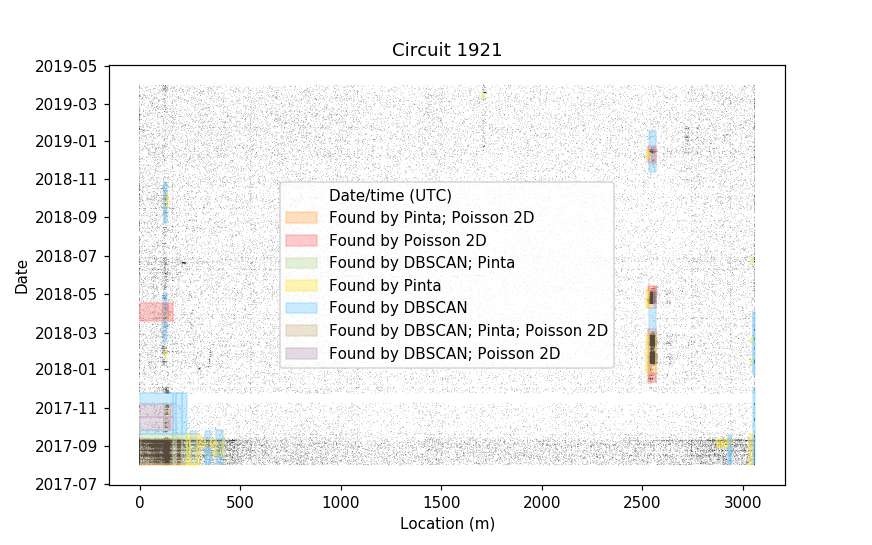

In [267]:
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [8, 5]

ax = plt.gca()
clusterizer.plot.draw_location_time_scatter(circuit, ax=ax, dot_size_to_charge_ratio=None)
clusterizer.plot.overlay_cluster_collection(ensemble_combined.get_clusters(), opacity=.4, scale_opacity_by_found_by_count=False)
clusterizer.plot.legend_without_duplicate_labels()
plt.show()

### clusterize_ensemble

Door algoritmes mee te geven aan clusterize_ensemble kun je in 1 keer meerdere algoritmes toepassen op een circuit. De resultaten van de algoritmes worden gecombineerd in een ClusterEnsemble.

In [ ]:
poisson_different_param = lambda circuit: clusterizer.algorithms.clusterize_poisson(circuit, certainty=.99999, name="Strict")
algorithms = [poisson_different_param, clusterizer.algorithms.clusterize_poisson, clusterizer.algorithms.clusterize_DBSCAN]
ensemble_combined = clusterizer.algorithms.clusterize_ensemble(circuit, algorithms)
print(ensemble_combined)

In [ ]:
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [8, 5]

clusters_poisson_e = [c for c in ensemble_combined.get_clusters() if c.found_by == {"Poisson 2D"}]
clusters_poisson_strict = [c for c in ensemble_combined.get_clusters() if c.found_by >= {"Strict"} and "DBSCAN" not in c.found_by]
clusters_DBSCAN_e = [c for c in ensemble_combined.get_clusters() if c.found_by == {"DBSCAN"}]
clusters_all = [c for c in ensemble_combined.get_clusters() if len(c.found_by) > 2]
clusters_poisson_DBSCAN = [c for c in ensemble_combined.get_clusters() if c.found_by == {"Poisson 2D", "DBSCAN"}]

ax = plt.gca()
clusterizer.plot.draw_location_time_scatter(circuit, ax=ax)
clusterizer.plot.overlay_cluster_collection(clusters_poisson_e, color="Red", ax=ax)
clusterizer.plot.overlay_cluster_collection(clusters_DBSCAN_e, color="Blue", ax=ax)
clusterizer.plot.overlay_cluster_collection(clusters_poisson_strict, color="#FFA71A", ax=ax)
clusterizer.plot.overlay_cluster_collection(clusters_poisson_DBSCAN, color="Purple", ax=ax)
clusterizer.plot.overlay_cluster_collection(clusters_both, color="Green", ax=ax)

plt.show()

In [ ]:
%matplotlib notebook

one_cluster = ensemble_combined.as_list()[0]

bounding_box = one_cluster.as_list()[0]
for c in one_cluster:
    bounding_box |= c

plt.cla()
ax = plt.gca()
clusterizer.plot.draw_location_time_scatter(circuit, ax=ax)
clusterizer.plot.overlay_cluster_collection([bounding_box], color="Red", ax=ax)